In [1]:
# Libraries used in the model are imported here for easy access
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

# Contents

# 1.0 Introduction
 In this project, I take the CRISP-DM (Cross-Industry Standard Process for Data Mining) approach to extract value from business data. The case study is an online retail company registered in the UK with customers from various countries. The raw dataset used for the project is available at the [UCI data repository](https://archive.ics.uci.edu/dataset/352/online+retail).  

The focus of this project is to demonstrate expertise in Data Management and Machine Learning operations. The project includes the establishment of an analytical Dimensional Database model using the star schema. To create more fields for the Database model, the base  dataset from UCI is augmented with generated data using the python faker library. Ultimately, only the original data is queried from the denormalized database and used to create a segmentation and recommendation system for the business.

# 2.0 Business Understanding

Like any typical online business, cross-selling and up-selling to existing customers is a key success factor. From their data records, the company in this case study has thousands of customers. It is inpractical to review their preferences manually and make related recommendations. It is also important for an online retail company to be aware of the habits of their customers so that they can tailor their advertisements and promotions to specific and relevant customer groups. An automated system that understands the customer's behaviour based on previous purchasing decisions will help the company resolve this challenge. The system could also go further to recommend relevant products to the customers. It is best if this recommendation takes place while the customer is still on the website, rather than via email campaigns or subsequent phone calls. The system therefore has to function in real-time.

# 3.0 Data Understanding


The business problem stipulated by the retail company can be resolved by creating a customer segmentation and recommendation system. This will use the customer information and purchase behaviour to group customers. Customers in the same class will be considered to have similar behaviour and thus make similar purchase decisions. The recommendation system will offer recommendations based on the classes.  

Information on the customers will be required to complete this analysis. The data on purchase history including prices, frequency of purchase, and originating country will be retrieved from the company to complete the analysis.

The company maintains a normalized database that is optimized for their transaction processing. A new database will be created that is optimized for analytical processing. It will be a denormalized dimensional model implemented in PostgreSQL.

The original data for the analysis contains the following features. There are no missing values in the data.

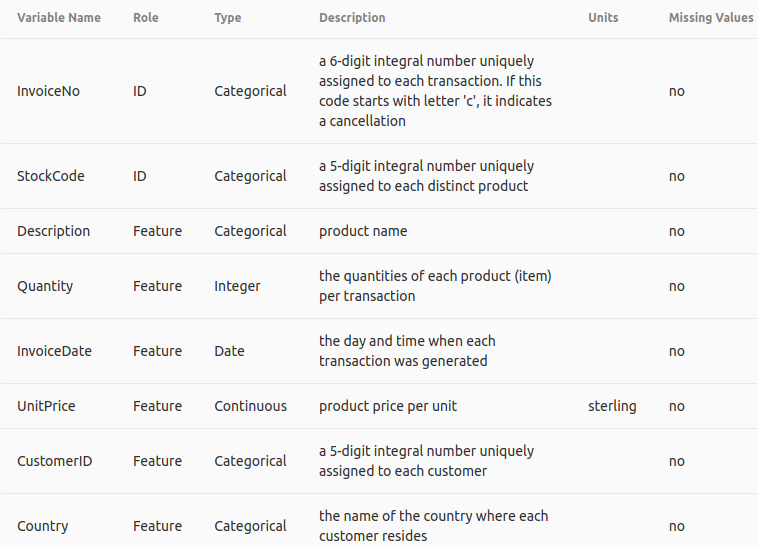  
source: [UCI data repository](https://archive.ics.uci.edu/dataset/352/online+retail)

# 3.1 Dimensional Modeling

Strictly speaking, a dimensional model is not required for this analysis. The required data could simply be extracted from the existing database using a simple SQL statement. A dimensional model will be created to demonstrate prowess.

## 3.1.1 Data Augmentation

In order to create more data fields for the model, a [python script](https://github.com/asoyewole/Datascience-Projects/blob/main/data_generation_script.py) is used to create additional data to augment the customer information from UCI. Additional data including Firstname, Lastname, Address, Phone, Email, and Password were created for all rows in the original dataset. 

In retrospect, creating a password column was unnecessary because user passwords will typically not form part of the data available to analysts. Additionally, handling passwords securely in a database requires encryption (hashing with Bcrypt or scrypt, salting) such that in essence, even the DataBase Administrator has no access to the raw passwords.

None of the 'fake' data will be used in the actual segmentation analysis.

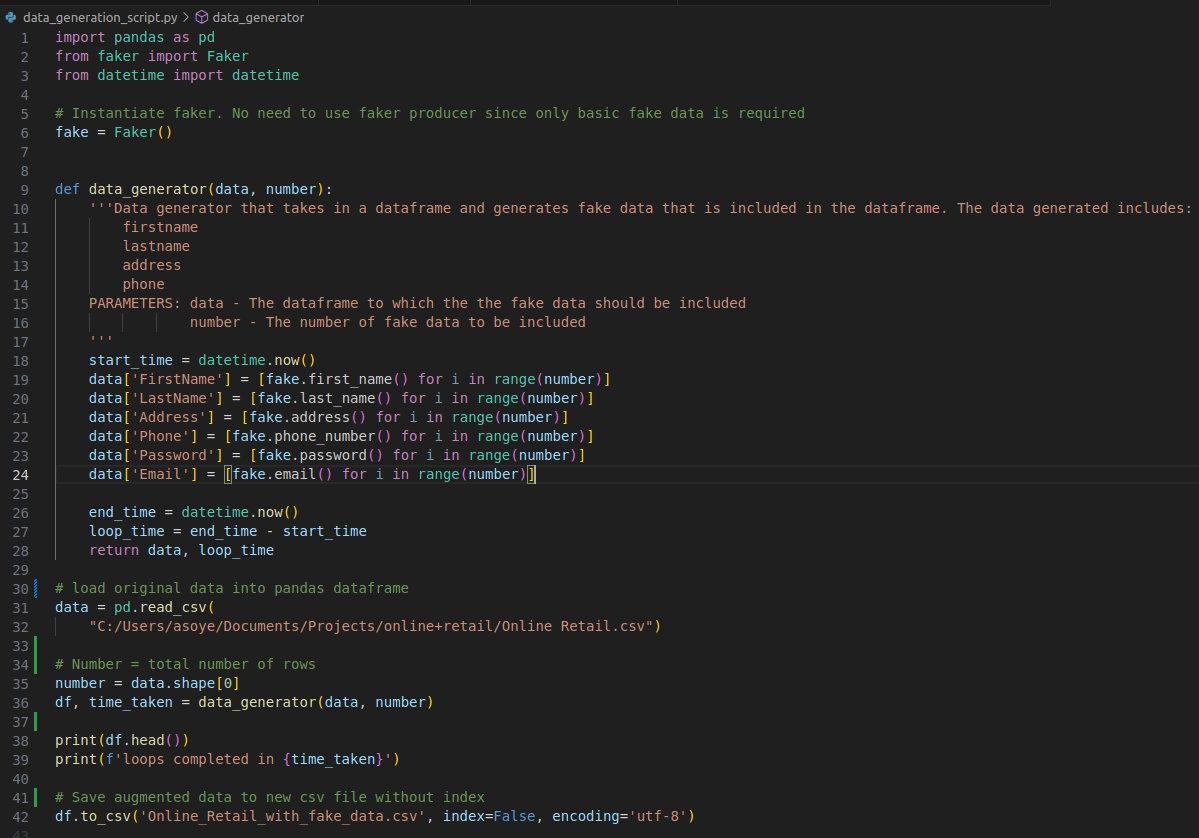  
Data generation script to augment original data with customer information.

## 3.1.2 Conceptual Model

The ERD (Entity Relationship Diagram) tool of PGAdmin4 was used to develop the conceptual model for the dimensional model. The fields available in the augmented data was spread across three tables based on how the dimensions relate with the measure. The tables in the dimensional model include Customer_dim, stock_dim and sales_measure. New fields were included in the dimension tables to serve as the primary key. They are serial, self-incrementing integers starting from one (1). The one to many relationships between the dimensions and the measure was established using foreign keys.  A staging table was also included in the conceptual model. The staging table would simple contain all the data. It is from this table that the tables in the dimensional model will be loaded using SQL scripts.  
  
![online retail star schema.png](<attachment:online retail star schema.png>)
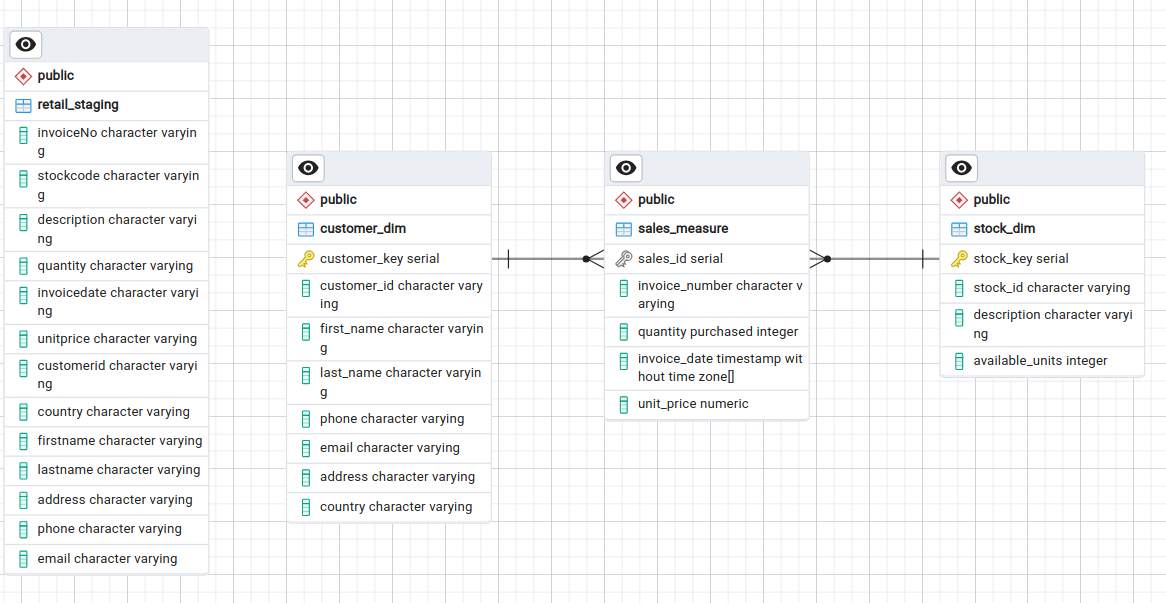

## 3.1.3 SQL and Bash Scripting

The conceptual database model created was forward engineered to generate the [SQL script](https://github.com/asoyewole/Datascience-Projects/blob/main/forward_engineered_table_creation_script.sql) for creating the database tables. Another [table_loading_script](https://github.com/asoyewole/Datascience-Projects/blob/main/table_loading_scripts.sql) was written to extract data from the staging table and load the two dimensions and the fact table. I did not generate data for the 'available units" field at the data augmentation stage. A code to generate data for this field was included in the table_loading_script.  

A bash script was written to execute all the SQL scripts. The postgreSQL password for accessing psql through the commandline was stored in a .pgpass file. It was therefore not necessary to include the password in the psql connection string. This way, if the dataset has regular updates with new events, the bash script would simply be set to run at regular intervals to update the database using crontab. In this case, a full load will be carried out whenever the bash script is executed. Incremental loading will be demonstrated in a different project.
  
  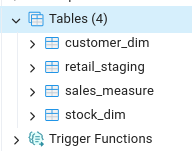  
    
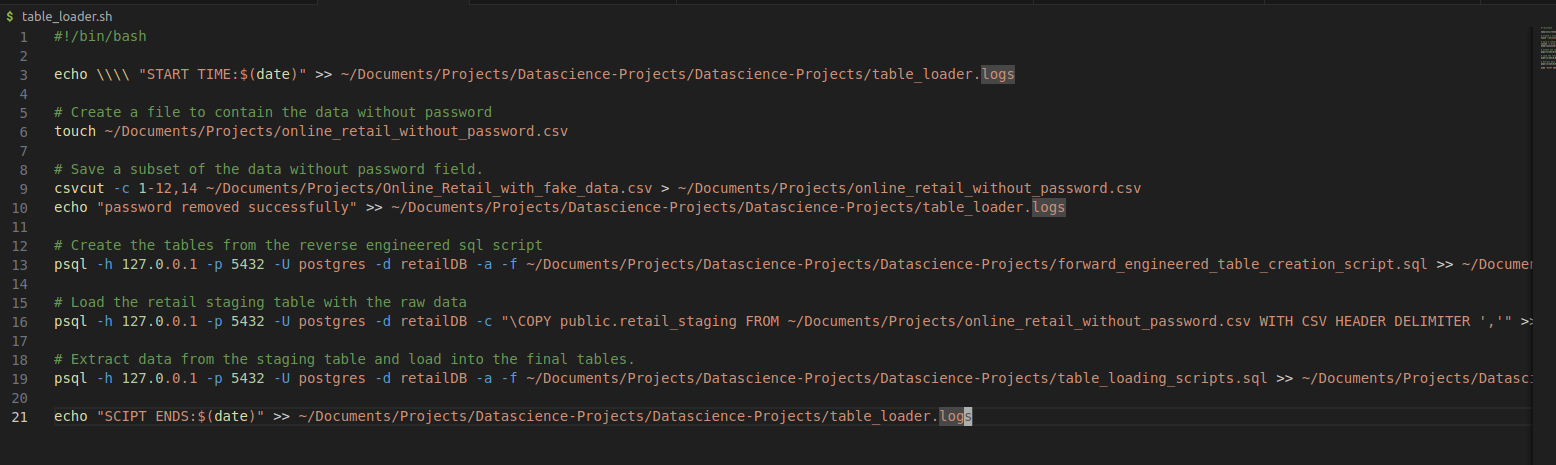  



# 4.0 Data Preparation  

The data needed for this analysis will be extracted from the database. For that a connection to the database is established using psycopg2. To avoid hard coding the password, an environment file is created in the same directory as this notebook. The password is saved in this file and loaded using os.getenv().

In [12]:
# Grab the password stored in .env file
load_dotenv()
pg_password = os.getenv('PASSWORD')
# Try connecting to the database
try:
    conn = psycopg2.connect(database = 'retailDB',
                                user = 'postgres',
                                password = pg_password,
                                host = 'localhost',
                                port = '5432')
    conn.autocommit = True
    cur = conn.cursor()
    print('Successfully connected')
except:
    print('connection failed')


Successfully connected


Using the connection already extablished, pandas read_sql function was used to extract the required data from the database using the sql statement saved as payload. Apparently pandas is more integrated with SQLAlchemy. I have still chosen to continue with psycopg2 becuase it interacts directly with the database and does not require translation of SQL codes as in the case of the SQLAlchemy engine. The user warning will thus be ignored.

In [14]:
try:
    payload = '''SELECT c.customer_id, c.country, 
                p.stock_id, p.description, 
                s."quantity purchased", s.invoice_number, s.invoice_date, s.unit_price
            FROM public.customer_dim as c
                LEFT JOIN public.stock_dim as p
                    ON c.customer_key=p.stock_key
                LEFT JOIN public.sales_measure as s
                    ON c.customer_key=s.sales_id'''

    df = pd.read_sql(payload, conn)

except:
    print('payload execution failed')
finally:
    cur.close()
    conn.close()

df.head()

/tmp/ipykernel_7145/910699444.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(payload, conn)


,customer_id,country,stock_id,description,quantity purchased,invoice_number,invoice_date,unit_price
0,13047.0,United Kingdom,21754,HOME BUILDING BLOCK WORD,3,536367,2010-12-01 08:34:00,5.95
1,17850.0,United Kingdom,21871,SAVE THE PLANET MUG,6,536373,2010-12-01 09:02:00,1.06
2,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,536375,2010-12-01 09:32:00,3.39
3,14688.0,United Kingdom,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,6,536378,2010-12-01 09:37:00,2.55
4,15311.0,United Kingdom,84854,GIRLY PINK TOOL SET,5,536381,2010-12-01 09:41:00,4.95


## 4.1 Exploratory Data Analysis

The following is a detailed exploratory analysis of the dataset to help understand the data further and to prepare the data for modelling.

### 4.1.1 Data Types and Data Count

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_id         406829 non-null  object        
 1   country             541909 non-null  object        
 2   stock_id            541909 non-null  object        
 3   description         540455 non-null  object        
 4   quantity purchased  541909 non-null  int64         
 5   invoice_number      541909 non-null  object        
 6   invoice_date        541909 non-null  datetime64[ns]
 7   unit_price          541909 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


The description and customer_id fields both contain some missing values. These two columns will be reviewed intricately to handle their missing values. All other columns do not have null values. 

The field for customer_id, country, stock_id, description, and invoice_number are all of object data types. Country and Description are texts indicating the 'country' and the 'description of the product' respectively. Data type object correctly fits the purpose. While integer datatypes may appear to fit the other object columns, they actually contain alpha-numeric characters (except customer_id which will be reviewed further subsequently). Thus object data type is fitting.

From the top 5 records previously printed, some customer_id are repeated for different records. This indicates multiple purchases. A customer may purchase more than one product.

The data description from the UCI repository also indicated that some invoice numbers start with 'C' to indicate canceled transactions.

### 4.1.2 Summary Statistics and Dispersion

In [17]:
df.describe()

,quantity purchased,invoice_date,unit_price
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


Quantity purchased, which represents the number of the product that was purchased has a mean of 9.55 and ranged between -80,995 and 80,995. The negative values indicate returned products or cancelled orders. With a standard deviation of 218, the data distribution is significantly dispersed around the mean.

The invoice date ranged from Dec 1, 2010 at 8:30am to Dec 9, 2011 at 12:50pm. The invoice date represents the timestamp of when the transaction occurred. 

The unit price also has negative values which may also have been used to express returned products. The maximum and minimum values of unit price are also large at 38,970 and -11,062 respectively. the standard deviation of 96.76 indicates significant dispersion of the data around the mean. 

In [18]:
df.describe(include='object')

,customer_id,country,stock_id,description,invoice_number
count,406829,541909,541909,540455,541909
unique,4372,38,4070,4223,25900
top,17841.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,573585
freq,7983,495478,2313,2369,1114


As previously indicated, the customer_id has 406,829 values, a difference of over 135,000 values from the columns with the highest number of records. There are about 4,300 unique customer_id. The customer with the highest number of transactions has almost 8,000 transactions.

The clients of this online retail company visit from 38 countries. Visitors from the UK account for more than 90% of their client base.

There are more than 4,000 unique stock_id representing the individual products. One of the stock_id has a frequency of 2,313. This could be the highest selling product. The summary figures for description are similar with those for stock_id.

There are almost 26,000 invoices. Some of the invoice numbers are also repeated since multiple products can be purchased on the same invoice.

## 4.2 Data Cleansing
Some missing values have already been identified in the data. They will be handled in this section. The dataset will also be reviewed to identify duplicates and treat them as necessary. They will be reviewed to identify if they are repeat transactions or duplicate transaction records for the same transaction.

### 4.2.1 Missing Data
